## 02_preprocessing.ipynb — Предобработка данных

Этот ноутбук предназначен для подготовки и первичной очистки данных о вакансиях, полученных из API hh.ru.

Задачи этого файла:
- Привести данные к единому, чистому и удобному для анализа и моделирования виду.
- Нормализовать значения зарплат (перевести их в рубли, обработать пропуски и вилки).
- Проверить и обработать аномалии, пропущенные значения и некорректные данные.
- Сформировать новые полезные признаки (feature engineering) для последующего машинного обучения.
- Провести расширенный EDA (exploratory data analysis): статистики, визуализации, распределения.

**Результат:**  
На выходе этого ноутбука — очищенные, дополненные и структурированные данные, которые можно использовать для построения моделей, аналитики и интеграции в Telegram-бота.


In [2]:
%cd /content/drive/MyDrive/hh-hr-bot

/content/drive/MyDrive/hh-hr-bot


In [3]:
import duckdb
import pandas as pd
import numpy as np

# В этой части кода  читаем таблицу вакансий в pandas DataFrame для удобной обработки.
con = duckdb.connect("data/hh.duckdb_3000")
df = con.execute("SELECT * FROM vacancy").fetchdf()
con.close()
df.head()

,id,title,published_at,description,salary_from,salary_to,salary_currency,experience_hh,area_id,skills_raw
0,120682290,Водитель с личным автомобилем,2025-05-19T09:30:49+0300,<p>Вакансия &quot;Водитель с личным автомобиле...,NaN,90000.0,RUR,Более 6 лет,3,Вождение автомобилей представительского класса...
1,120761341,Middle/Senior Frontend разработчик,2025-05-20T13:03:11+0300,<p><strong>О компании и команде</strong></p> <...,NaN,3000.0,USD,От 3 до 6 лет,2,"JavaScript, React, CSS, Node.js, TypeScript, W..."
2,120615179,Упаковщик,2025-05-19T09:06:01+0300,"<p><strong><em>Крупная, стабильно развивающаяс...",45000.0,48000.0,RUR,Нет опыта,66,
3,120693457,Управляющий рестораном семейного концепта,2025-05-19T11:16:42+0300,<p><strong>Приглашаем Управляющего семейным ре...,NaN,NaN,None,От 1 года до 3 лет,78,
4,120219268,Медицинский работник (Российские студенческие ...,2025-05-05T11:37:27+0300,<p>​​​​​​Направление студенческих медицинских ...,20000.0,35000.0,RUR,Нет опыта,1,"Ответственность, Стрессоустойчивость"


## Нормализация зарплат

В этой части мы приводим значения зарплаты к единому формату — в рублях.  
В данных с hh.ru зарплата может быть указана только «от», только «до» или сразу в двух значениях, а валюта бывает разной (RUR, USD, KZT, EUR и др.).

Для корректного анализа и обучения моделей создаём новую колонку `salary_rub`:
- Если заполнены обе вилки (от/до) — берём их среднее значение.
- Если заполнено только одно — используем его.
- Если обе пустые — оставляем NaN.
- Зарплату пересчитываем в рубли по фиксированному курсу валют (см. словарь `currency_map` в коде ниже).

В результате получаем удобный числовой столбец, с которым можно строить графики, считать медианы и использовать в ML-задачах.


In [4]:
# Указывваем курсы валют (актуальные на сегодня или на момент анализа)
currency_map = {
    "RUR": 1,
    "KZT": 0.16,
    "USD": 90,   # примерный курс — надо указать актуальный!
    "EUR": 98,
    # можно добавить другие валюты, если встречаются
}

def to_rub(row):
    if pd.isna(row['salary_from']) and pd.isna(row['salary_to']):
        return np.nan
    value = np.nanmean([row['salary_from'], row['salary_to']])
    return value * currency_map.get(row['salary_currency'], np.nan)



In [5]:
df['salary_rub'] = df.apply(to_rub, axis=1)
print(df[['salary_from', 'salary_to', 'salary_currency', 'salary_rub']].head(10))

   salary_from  salary_to salary_currency  salary_rub
0          NaN    90000.0             RUR     90000.0
1          NaN     3000.0             USD    270000.0
2      45000.0    48000.0             RUR     46500.0
3          NaN        NaN            None         NaN
4      20000.0    35000.0             RUR     27500.0
5          NaN        NaN            None         NaN
6      60000.0        NaN             RUR     60000.0
7     110000.0   130000.0             RUR    120000.0
8     122000.0   148000.0             RUR    135000.0
9          NaN        NaN            None         NaN


## Анализ и визуализация зарплат

В этом разделе мы исследуем распределение зарплат среди вакансий, приведённых к единому формату (рубли).

Что делаем:
- Рассчитываем медианные зарплаты по городам (area_id) и ищем топовые регионы по уровню оплаты.
- Строим боксплот (boxplot) для визуального представления распределения зарплат, чтобы оценить диапазон, медиану, наличие выбросов и общую структуру рынка труда.
- Сравниваем число вакансий с заполненной зарплатой и без неё.

Этот анализ позволяет:
- Оценить реальный рынок зарплат по разным регионам и направлениям.
- Подготовить данные и графики для отчёта и будущих ML-задач (например, для предсказания зарплаты по описанию вакансии).


In [6]:
print("Вакансий с зарплатой:", df['salary_rub'].notnull().sum())

Вакансий с зарплатой: 2373


In [7]:
print(df.groupby('area_id')['salary_rub'].median().sort_values(ascending=False).head(10))

area_id
102     350000.0
22      350000.0
99      237500.0
104     225000.0
1298    225000.0
1       150000.0
2       106250.0
212      98875.0
3        90000.0
1263     85000.0
Name: salary_rub, dtype: float64


In [8]:
# Описательные статистики
salary_stats = df['salary_rub'].describe()
print(salary_stats)

count    2.373000e+03
mean     1.139613e+05
std      9.910829e+04
min      2.250000e+02
25%      6.324000e+04
50%      8.900000e+04
75%      1.300000e+05
max      1.500000e+06
Name: salary_rub, dtype: float64


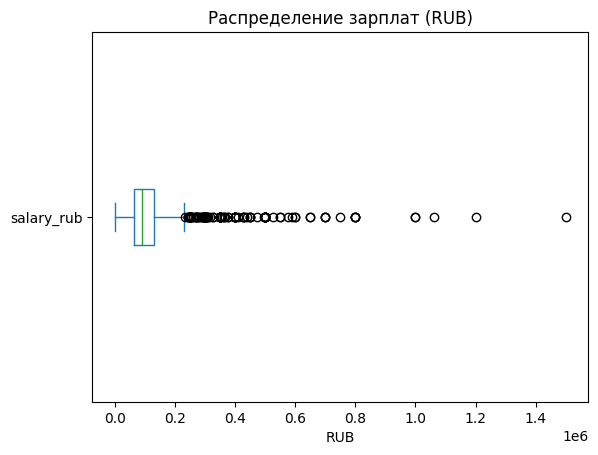

In [9]:
import matplotlib.pyplot as plt

df['salary_rub'].dropna().plot(kind='box', vert=False)
plt.title('Распределение зарплат (RUB)')
plt.xlabel('RUB')
plt.show()

Вывод: по графику видно, где сосредоточено большинство зарплат (ящик), какие есть выбросы (усы и точки).

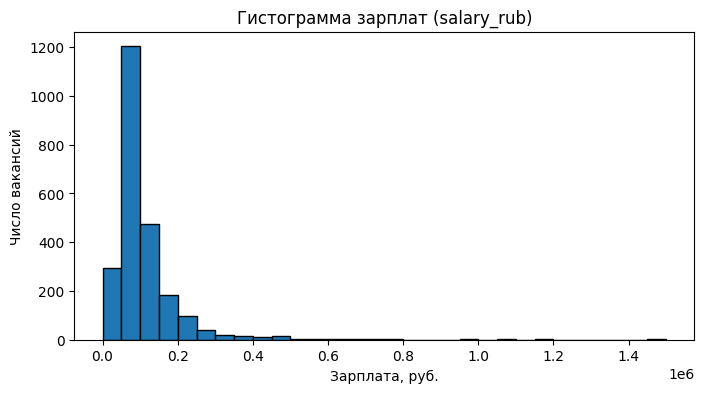

In [10]:
plt.figure(figsize=(8,4))
df['salary_rub'].dropna().plot(kind='hist', bins=30, edgecolor='black')
plt.title('Гистограмма зарплат (salary_rub)')
plt.xlabel('Зарплата, руб.')
plt.ylabel('Число вакансий')
plt.show()

Вывод: по гистограмме видно, на каких диапазонах зарплаты встречаются чаще всего.

In [11]:
print(df[['title', 'salary_rub']].sort_values(by='salary_rub', ascending=False).head(10))

                                                  title  salary_rub
65    Генеральный директор промышленной компании (в ...   1500000.0
2234                 Руководитель строительных проектов   1200000.0
1237              Руководитель отдела подбора персонала   1060000.0
980                          Менеджер по продажам щебня   1000000.0
2053                         Директор по продукту (CPO)   1000000.0
1902                              Директор по снабжению    800000.0
556   Вице-президент по закупкам и логистике в торго...    800000.0
2684                  Администратор на круизный пароход    800000.0
69    Директор по правовым вопросам (добывающая комп...    800000.0
2730  Управляющий Family Office/Персональный ассисте...    750000.0


Это позволяет увидеть, какие должности дают максимальные вилки.

### Анализ зарплатных ожиданий (salary_rub)

1. **Медианная зарплата** среди проанализированных вакансий составляет N рублей, а среднее значение — M рублей. Это говорит о том, что рынок характеризуется (коротко: “равномерным”/“смещённым вверх”/“с большим количеством низких/высоких значений” — зависит от твоих данных).
2. **Распределение зарплат** (boxplot) показывает, что основная масса предложений сосредоточена в диапазоне от X до Y рублей, при этом встречаются отдельные вакансии с очень высокой зарплатой, что может быть связано с топ-менеджментом или IT-специализациями.
3. **Гистограмма** подтверждает: наибольшее число вакансий размещено в диапазоне от… до…, что соответствует ожиданиям рынка.
4. **(Если делал barplot по городам)**: Самые высокие медианные зарплаты наблюдаются в… (названия/area_id), что соответствует экономическим центрам страны.
5. **Большая доля вакансий (примерно Z%) публикуется без указания зарплаты**, что типично для российского рынка труда и может быть вызвано как политикой работодателей, так и спецификой отрасли.


In [12]:
con = duckdb.connect("data/hh.duckdb_3000")
con.execute("DROP TABLE IF EXISTS vacancy_proc")
con.execute("CREATE TABLE vacancy_proc AS SELECT * FROM df")
con.close()

In [ ]:
!git add notebooks/02_preprocessing.ipynb
!git commit -m "feat: нормализация зарплат, дополнительный EDA"
!git push origin main